In [ ]:
!pip install -q keras-tuner
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2, mobilenet_v2
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tqdm.keras import TqdmCallback
import matplotlib.pyplot as plt


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.3 MB/s eta 0:00:00


In [ ]:
BATCH_SIZE = 16
IMG_SIZE = 160
EPOCHS = 14
FINE_TUNE_EPOCHS = 8
NUM_CLASSES = 10


In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
y_train_cat = to_categorical(y_train, NUM_CLASSES)
y_test_cat = to_categorical(y_test, NUM_CLASSES)


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = mobilenet_v2.preprocess_input(image)
    return image, label


In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])


In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train_cat)).map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(5000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test_cat)).map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [ ]:
del x_train, y_train, x_test, y_test


In [ ]:
def build_model(fine_tune=False, fine_tune_at=100):
    base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))

    if fine_tune:
        base_model.trainable = True
        for layer in base_model.layers[:fine_tune_at]:
            layer.trainable = False
    else:
        base_model.trainable = False

    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = data_augmentation(inputs)

    x = base_model(x, training=False)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)

    outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

    model = models.Model(inputs, outputs)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4 if not fine_tune else 1e-5),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [ ]:
model = build_model(fine_tune=False)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print("Training MobileNetV2 (frozen)...")
history = model.fit(train_ds, validation_data=test_ds, epochs=EPOCHS,
                    callbacks=[TqdmCallback(verbose=1)], verbose=0)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training MobileNetV2 (frozen)...


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

In [ ]:
print("Fine-tuning MobileNetV2...")
model.trainable = True
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

fine_tune_history = model.fit(train_ds, validation_data=test_ds, epochs=FINE_TUNE_EPOCHS,
                              callbacks=[TqdmCallback(verbose=1)], verbose=0)


Fine-tuning MobileNetV2...


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

In [ ]:
loss, acc = model.evaluate(test_ds, verbose=2)
print(f"\n✅ Final Test Accuracy (MobileNetV2): {acc:.4f}")


625/625 - 11s - 17ms/step - accuracy: 0.8660 - loss: 0.3982

✅ Final Test Accuracy (MobileNetV2): 0.8660


In [ ]:
def plot_history(histories, titles):
    for history, title in zip(histories, titles):
        plt.plot(history.history['val_accuracy'], label=f'{title} val_acc')
    plt.title("Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

    for history, title in zip(histories, titles):
        plt.plot(history.history['val_loss'], label=f'{title} val_loss')
    plt.title("Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

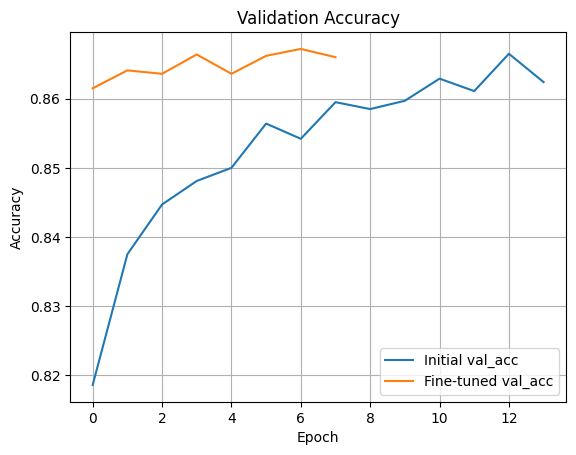

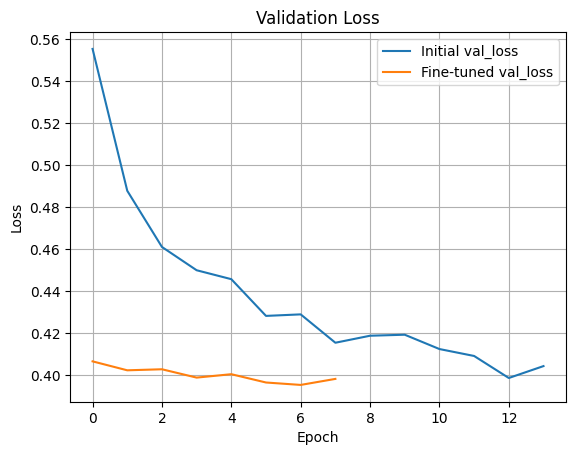

In [ ]:
plot_history([history, fine_tune_history], ["Initial", "Fine-tuned"])
